In [16]:
from utils.analytical.utils import *
import warnings
warnings.filterwarnings('ignore')

# 3.1 Analytical Method
This chapter presents a detailed methodology for estimating external joint torques on a LARA8 equipped with Harmonic Drive Transmissions (HDTs) and dual encoders. Starting from measuring the transmission error using the dual encoders, the approach focuses on modelling and compensating for the transmission errors caused by known torques. The primary hypothesis is that any remaining deformation can be attributed to external forces by accounting for these known torques, thereby isolating the external joint torque.

To streamline the study's complexity and achieve precise torque estimations, the research was concentrated on a single robot joint. By focusing on a single joint, the number of variables that could influence the accuracy of the results is decreased and a more controlled and thorough analysis of the torque components is possible. Joint 3 was selected because of its greater range of motion and the large torque loads it usually encounters. This joint's configuration and operation make it particularly suitable for studying the effects of various torque components, both internal and external.


## 3.1.1 Experimental Setup and Data Collection

The robot was mounted horizontally, with its base attached to a vertical plane, positioning Joint 3 parallel to the gravity vector and allowing it to rotate in a Horizontal plane. This orientation effectively eliminated gravitational torque components on Joint 3, enabling a focused study on internal torques such as frictional and position-dependent torques. In this configuration, Joint 3 was rotated from its maximum limit in one direction to the maximum limit in the opposite direction, while all other joints remained fixed at 0°, thus covering the entire range of motion from -150° to 150°. Each recorded motion was done with randomly chosen joint velocity from a uniform distribution ranging from 0.01 rad/s to 1.15rad/s.

Data collection included recording joint velocity, joint angle, torque feedforward, load-side encoder counts, and motor-side encoder counts at every 2 ms interval. This high-resolution data sampling ensured that detailed and accurate information was captured.

In [3]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("analytical_dataset")
data = preprocess()

downloading data:   0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

As discussed in Section 2, transmission error 𝜃𝑒 can be represented by the following equation.
$$
\theta_e = \frac{\theta_m}{N }- \theta_l
$$
where $\theta_m$ corresponds to the input motor shaft position, $N$ is the gear ratio
and $\theta_l$ pertains to the output load shaft position. This equation captures the difference between the scaled motor position and the actual load position, effectively measuring the torsional deformation within the Harmonic Drive Transmission.

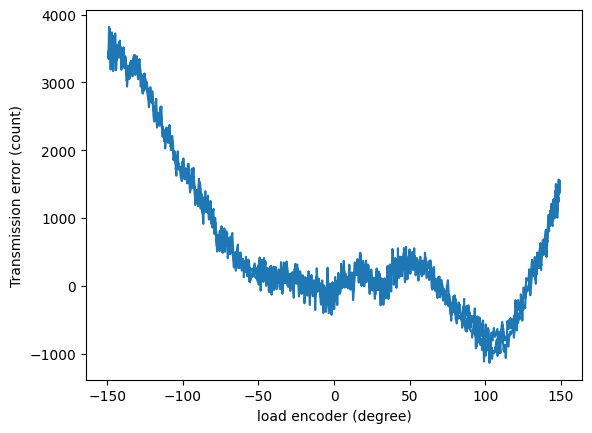

In [4]:
# A random sample from the collected data is selected, and its Transmission error is visualized
import random 

sample = random.choice(list(data.keys()))

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3)
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder (degree)')
plt.show()

The encoder data received is notably affected by significant noise. To rectify this, a low-pass filter with a cut-off frequency set at 50 Hz is applied. This filter reduces the noise while preserving the integrity of the original data.

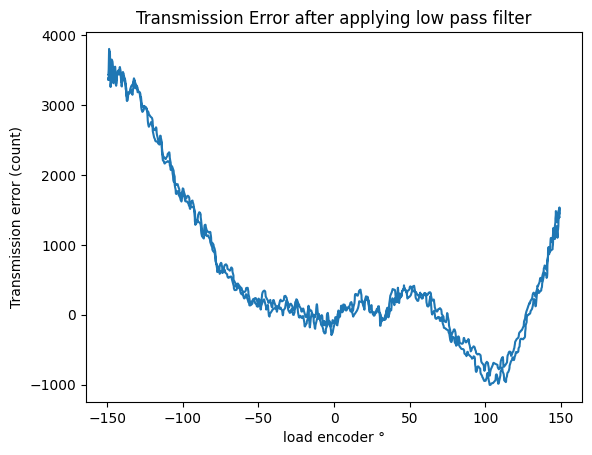

In [18]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.title("Transmission Error after applying low pass filter")
plt.show()

## 3.1.2 Position Based Error

To model the characteristic position-based error, often called the "footprint," it is essential to understand the nature of transmission errors in harmonic drive systems. One source of these errors is torque caused by gear eccentricity and tooth profile errors specific to each Harmonic Drive Transmission.
The transmission error exhibits periodic behaviour in relation to the joint position. Building on earlier research[cite], a Fourier series model captures this periodic nature well. This model decomposes the error into sine and cosine terms, each representing different frequency components associated with the gear's rotational position. A lookup table is an additional option to represent the transmission error. The  formula for the Fourier series used to model the transmission error is as follows:
$$
θ_e(θ_m,θ_l)=A_0+\Sigma^{10}_{n=1}[A_ncos(\omega_{m(n)}θ_m)+B_nsin(\omega_{m(n)}θ_m)] + \Sigma^{30}_{n=1}[C_ncos(nθ_l)+D_nsin(nθ_l)]
$$

Here, $A_0$ represents the static offset, which can be influenced by factors such as the direction of motion and any consistent bias in the system. The coefficients $A_n$,$B_nC_n$ and $D_n$ correspond to the amplitude of the cosine and sine components at each harmonic frequency $\omega_m$. These coefficients are determined based on empirical data, capturing the specific characteristics of the transmission error for a given harmonic drive.

The slowest speed among the collected data sets was selected for further analysis to minimize the effects of dynamic forces such as Coriolis and centrifugal terms. This selection ensured that the torques associated with accelerating and decelerating the joint at this low velocity were negligible and of minimal duration. This focus allowed for isolating primarily frictional and position-dependent torques, providing the clearest data for accurately modeling the characteristic position-based error in the harmonic drive system.

RMS value residual error: 0.007256666600305171
RMS value actual error: 0.03714619456727632
The Model has reduced the error


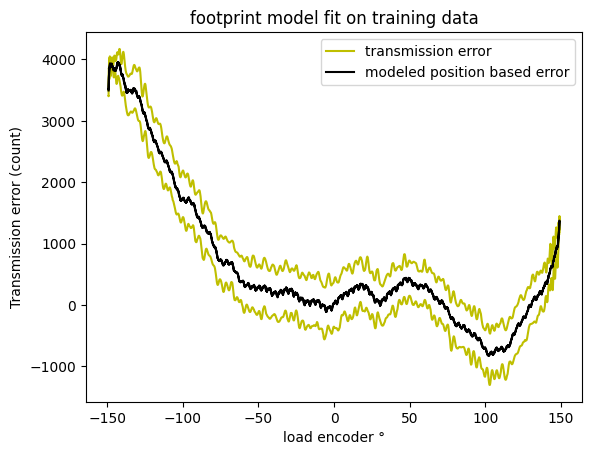

In [6]:
#learn characteristic footprint error from the slowest data 
footprint_coeff = model_footprint(data["0.97"])
np.save("utils/analytical/footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg, (data["0.97"].filtered_motor_enc/gear_ratio - data["0.97"].filtered_load_enc) ,'y',label = 'transmission error')
plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].modeled_footprint/count_to_deg,'black',label = 'modeled position based error')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training data")
plt.show()

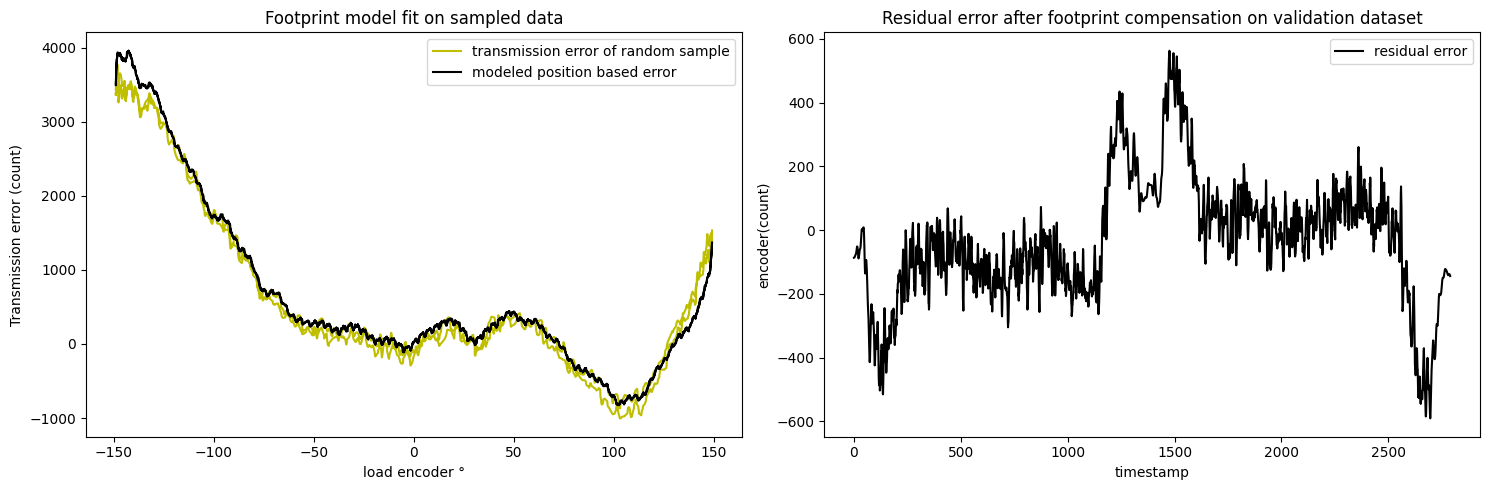

In [15]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First plot: Footprint model fit on sampled data
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         (data[sample].filtered_motor_enc / gear_ratio - data[sample].filtered_load_enc), 'y', label='transmission error of random sample')
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         data[sample].modeled_footprint / count_to_deg, 'black', label='modeled position based error')
ax1.set_ylabel('Transmission error (count)')
ax1.set_xlabel('load encoder °')
ax1.legend()
ax1.set_title("Footprint model fit on sampled data")

# Calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc / gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint / count_to_deg

# Second plot: Residual error after footprint compensation on validation dataset
ax2.plot(data["0.27"].residual_error, 'black', label='residual error')
ax2.set_ylabel('encoder(count)')
ax2.set_xlabel('timestamp')
ax2.legend()
ax2.set_title("Residual error after footprint compensation on validation dataset")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

## 3.1.3 Dynamic Torque Compensation
The dynamic torque (eqn ref in chap 2) is a component of the output torque from the transmission. The torque feedforward also includes a friction component (eqn ref), which accounts for friction in the motor and other parts of the joint, including the HDT. Since a portion of the friction torque is already dissipated within the motor, only the part attributable to the encoder difference needs to be compensated. As a result, the entire friction component is removed from this torque, and compensation ensures that the inherent dynamic effects of the robot's motion are subtracted. This process provides a clear basis for isolating and accurately estimating the external joint torques

In [8]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] = data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation

## 3.1.4 Friction compensation
The only remaining torque to be modelled is the frictional torque in the HDT, which is velocity-dependent. Using the friction model below, the parameters were identified through non-linear least squares fitting [cite], aligning the model with the observed frictional behaviour:
$$
f(v) = a_1 (\tanh(b_1 v) - \tanh(b_2 v)) + a_2 \tanh(b_3 v) + a_3 v
$$
where $v$ represents the joint velocity, $a_1,a_2,a_3 ,b1,b2,b3$ are parameters that are found in the fitting. Since encoder error is synonimous to torque, the model was used in this study to map velocity to transmission error instead of the original model's intended mapping of torque to velocity [cite]. This adaptation effectively represents the frictional torque component through transmission error, encapsulating the characteristics of the friction present in the system.

In [19]:
def friction_model(v,a1,a2,a3,b1,b2,b3):
    return a1*(np.tanh(b1*v)-np.tanh(b2*v))+a2*np.tanh(b3*v)+a3*v

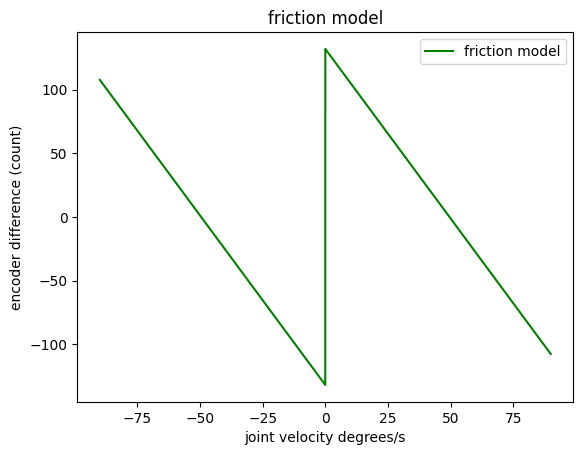

In [20]:
#append all dataframes
dfs = data[sample].iloc[:0,:].copy()
for key in data:
    dfs=pd.concat([dfs,data[key]])

#model friction
parameters,_ = curve_fit(friction_model,dfs.joint_velocity_3*radian_to_deg,dfs.residual_error2)
#save variables to file
np.save("utils/analytical/friction_coeff.npy",parameters)

y = np.arange (-90, 90, 0.01)
x = friction_model(y,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5])
plt.plot(y,x,'g',label='friction model')
plt.legend()
plt.xlabel("joint velocity degrees/s")
plt.ylabel("encoder difference (count)")
plt.title("friction model")
plt.legend()
plt.show()
plt.close()


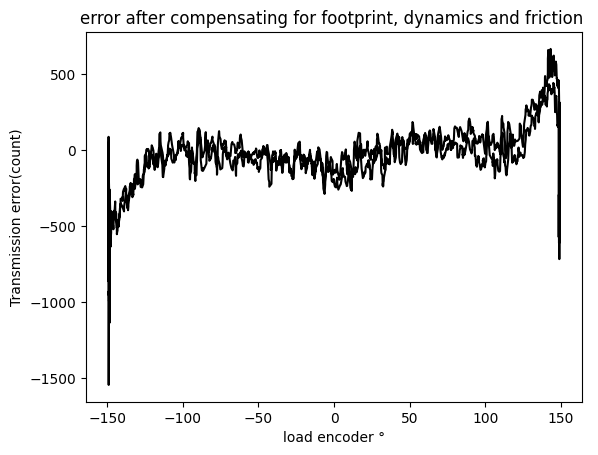

In [24]:
#comepnesate for friction
for key in data:
    data[key]['modeled_friction'] = data[key].apply(lambda row: friction_model(row["filtered_joint_velocity"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction
    

plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].residual_error3,'black')
plt.ylabel('Transmission error(count)')
plt.xlabel('load encoder °')
plt.title("error after compensating for footprint, dynamics and friction ")
plt.show()

## 3.1.5 External Torque 
The residual transmission error can now be converted to torque using [eqn ref]

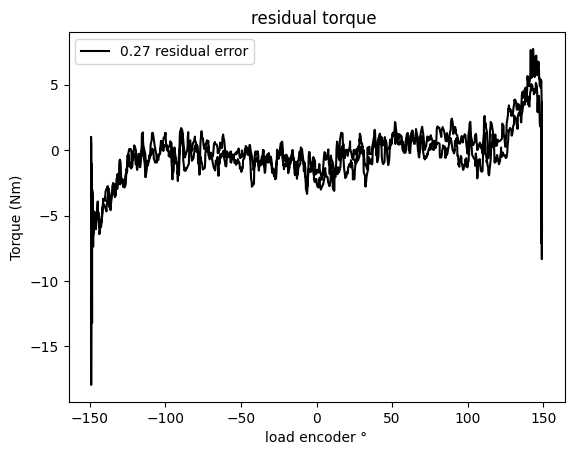

In [12]:
#comepnesate for friction
for key in data:
    data[key]['torque_estimate'] = data[key].apply(lambda row: encoder_error_to_torque(row["residual_error3"]),axis=1)
plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].torque_estimate,'black',label = '0.27 residual error')
plt.ylabel('Torque (Nm)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("residual torque ")
plt.show()
plt.close()    

The remaining residual torque, after compensating for all known components, indicates the presence of unmodeled torques or inaccuracies within the existing torque models. According to our hypothesis, this residual torque corresponds to the unaccounted external forces acting on the system. However, the existence of these residuals suggests that the current models do not fully capture all dynamic effects. These findings motivate the need for a more robust approach, potentially incorporating multiple sources of torque information, such as motor currents. This observation leads to the next chapter, where machine learning techniques are employed to learn and model the external torques.